In [ ]:
library(dplyr)
library(MatchIt)
library(lmtest)
library(sandwich)
library(marginaleffects)
library(wnominate)
library(ggplot2)
library(gridExtra)

DATA

Inicialmente, pegamos todos os arquivos que foram tratados via Python, utilizando os valores dados na aba abaixo.

In [42]:
get_tema_data <- function(TEMA) {
  output_folder <- './output/treated/'
  df_votos_file <- paste('df_votos', tolower(TEMA), sep='_')
  matched_data_file <- paste('df_matched_data', tolower(TEMA), sep='_')
  
  df_parls <- read.csv(paste(output_folder, 'df_parls', '.csv', sep=''))
  df_votos <- read.csv(paste(output_folder, df_votos_file, '.csv', sep=''))
  df_merge <- merge(df_parls, df_votos)
  
  return(df_merge)
}

In [43]:
TEMAS <- c("Geral", "Reforma da Previdência") # "FUNDEB", "Energia Renovável",  "Homeschooling"

In [55]:
data_temas <- list()
for (tema in TEMAS) {
   data_temas[[tema]] <- get_tema_data(tema)
}

# WNOMINATE
Calcular o W-Nominate.

O parlamentar usado como referencia para a polaridade foi o 115746 (Gelson Azevedo - PL) por ser considerado como empresário e esteve ausente em apenas 2 votações do total considerado.

In [20]:
compute_wnominate <- function(df){
    legData <- df[,0:53]
    votos <- df[,54:length(df_merge)]

    rc <- rollcall(
        votos, 
        yea=1, 
        nay=-1, 
        missing=0,  
        notInLegis=NA, 
        legis.names=legData$id_parl, 
        legis.data=legData
    )
    result <- wnominate(
      rc, 
      polarity = c('115746', '115746'),
      minvotes=10
    )

    return(result$legislators)
}

generate_boxplot_plot <- function(df_wn, TEMA) {
  boxplot_plot <- ggplot(
    data = df_wn,
    mapping = aes(x = coord1D, y = coord2D, color = factor(is_empresario))
  ) + 
  geom_point(size = 3, alpha = 7/10) + 
  scale_y_continuous(limits = c(-1, 1)) + 
  scale_x_continuous(limits = c(-1, 1)) + 
  coord_fixed(ratio = 1) +
  labs(title = TEMA) +  # Use TEMA as the plot title
  scale_colour_manual(
    values = c("0" = "darkblue", "1" = "orange"),
    breaks = c("0", "1"),
    labels = c("Não Empresário", "Empresário")
  ) +
  theme(legend.position = "none")

  # Add a circle of radius 1 centered at the origin
  circle_data <- data.frame(
    x = cos(seq(0, 2 * pi, length.out = 100)),
    y = sin(seq(0, 2 * pi, length.out = 100))
  )

  # Add the circle using geom_polygon
  circle_plot <- boxplot_plot +
    geom_polygon(data = circle_data, aes(x, y), color = "gray", fill = NA)

  return(circle_plot)
}


In [56]:
# Initialize an empty list to store plots
plot_list <- list()
df_wn_list <- list()

# Loop through TEMAS and generate plots
for (tema in TEMAS) {
  df_merge <- data_temas[[tema]]

  print(paste("Calculando W-Nominate para o tema: ", tema))

  df_wn <- compute_wnominate(df_merge)  
  plot <- generate_boxplot_plot(df_wn, tema)

  plot_list[[tema]] <- plot
  df_wn_list[[tema]] <- df_wn
}



[1] "Calculando W-Nominate para o tema:  Geral"

Preparing to run W-NOMINATE...

	Checking data...

		... 25 of 559 total members dropped.

		Votes dropped:
		... 4 of 61 total votes dropped.

	Running W-NOMINATE...

		Getting bill parameters...
		Getting legislator coordinates...
		Starting estimation of Beta...
		Getting bill parameters...
		Getting legislator coordinates...
		Starting estimation of Beta...
		Getting bill parameters...
		Getting legislator coordinates...
		Getting bill parameters...
		Getting legislator coordinates...
		Estimating weights...
		Getting bill parameters...
		Getting legislator coordinates...
		Estimating weights...
		Getting bill parameters...
		Getting legislator coordinates...


W-NOMINATE estimation completed successfully.
W-NOMINATE took 7.765 seconds to execute.

[1] "Calculando W-Nominate para o tema:  Reforma da Previdência"

Preparing to run W-NOMINATE...

	Checking data...

		... 2 of 511 total members dropped.

		Votes dropped:
		... 2 of 42 t

In [ ]:
combined_plots <- do.call(grid.arrange, c(plot_list, ncol = 2))

# Models

Modelos para avaliar os efeitos de X na coord1D sem pareamento

In [28]:
X1 = c('is_empresario')
X2 = c('is_empresario', 'governismo')
X3 = c(
    'is_empresario',
    'governismo',
    'uf_AC',
    'uf_AL',
    'uf_AM',
    'uf_AP',
    'uf_BA',
    'uf_CE',
    'uf_DF',
    'uf_ES',
    'uf_GO',
    'uf_MA',
    'uf_MG',
    'uf_MS',
    'uf_MT',
    'uf_PA',
    'uf_PB',
    'uf_PE',
    'uf_PI',
    'uf_PR',
    'uf_RJ',
    'uf_RN',
    'uf_RO',
    'uf_RR',
    'uf_RS',
    'uf_SC',
    'uf_SE',
    'uf_TO'
)
X4 = c(
    'is_empresario',
    'governismo',
    'uf_AC',
    'uf_AL',
    'uf_AM',
    'uf_AP',
    'uf_BA',
    'uf_CE',
    'uf_DF',
    'uf_ES',
    'uf_GO',
    'uf_MA',
    'uf_MG',
    'uf_MS',
    'uf_MT',
    'uf_PA',
    'uf_PB',
    'uf_PE',
    'uf_PI',
    'uf_PR',
    'uf_RJ',
    'uf_RN',
    'uf_RO',
    'uf_RR',
    'uf_RS',
    'uf_SC',
    'uf_SE',
    'uf_TO',
    'partido_AVANTE',
    'partido_CIDADANIA',
    'partido_MDB',
    'partido_NOVO',
    'partido_PATRIOTA',
    'partido_PCdoB',
    'partido_PDT',
    'partido_PL',
    'partido_PODE',
    'partido_PP',
    'partido_PROS',
    'partido_PSB',
    'partido_PSC',
    'partido_PSD',
    'partido_PSDB',
    'partido_PSOL',
    'partido_PTB',
    'partido_PV',
    'partido_REDE',
    'partido_REPUBLICANOS',
    'partido_SOLIDARIEDADE',
    'partido_UNIÃO'
)
partidos <- c(
    'partido_AVANTE',
    'partido_CIDADANIA',
    'partido_MDB',
    'partido_NOVO',
    'partido_PATRIOTA',
    'partido_PCdoB',
    'partido_PDT',
    'partido_PL',
    'partido_PODE',
    'partido_PP',
    'partido_PROS',
    'partido_PSB',
    'partido_PSC',
    'partido_PSD',
    'partido_PSDB',
    'partido_PSOL',
    'partido_PTB',
    'partido_PV',
    'partido_REDE',
    'partido_REPUBLICANOS',
    'partido_SOLIDARIEDADE',
    'partido_UNIÃO'
)

In [30]:
model1 <- lm(reformulate(X1, response = 'coord1D'), data=df_wn)
model2 <- lm(reformulate(X2, response = 'coord1D'), data=df_wn)
model3 <- lm(reformulate(X3, response = 'coord1D'), data=df_wn)
model4 <- lm(reformulate(X4, response = 'coord1D'), data=df_wn)

In [37]:
summary(model1)


Call:
lm(formula = reformulate(X1, response = "coord1D"), data = df_wn)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.81783 -0.34602  0.04204  0.29562  1.10620 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -0.26731    0.02098 -12.739   <2e-16 ***
is_empresario  0.08795    0.03664   2.401   0.0167 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3881 on 507 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.01124,	Adjusted R-squared:  0.00929 
F-statistic: 5.763 on 1 and 507 DF,  p-value: 0.01672


# PSM

In [46]:
matched_objs <- list()

for (tema in TEMAS) {
   match_obj <- matchit(
    formula = reformulate(X4[-c(1)], response = 'is_empresario'), 
    data = df_wn_list[[tema]], 
    method = "nearest", 
    distance = "glm",
    # link = "probit",
    replace = FALSE, 
    ratio = 1,
    # exact = reformulate(partidos)
    )

    matched_objs[[tema]] <- match_obj
}


In [ ]:
plot(match_obj, type = "jitter", interactive = FALSE)
plot(summary(match_obj), abs = FALSE)
plot(match_obj, type = "density", interactive = FALSE,
     which.xs = ~governismo)

Testar efeitos de ser empresário na coord1D com pareamento

In [53]:
for (tema in TEMAS) {
    matched_data <- match.data(matched_objs[[tema]])

    print(paste("Tema:", tema, "| Total linhas:", nrow(matched_data)))

    fit <- lm(coord1D ~ is_empresario, data = matched_data, weights = weights)

    #Test the coefficient using cluster robust standard error
    res_test <- coeftest(fit, vcov. = vcovCL, cluster = ~ subclass, weights = weights)
    #Calculate the confidence intervals based on cluster robust standard error
    res <- coefci(fit, vcov. = vcovCL, cluster = ~ subclass, level = 0.95, weights = weights)
    print(res_test, res)
}

[1] "Tema: Geral | Total linhas: 378"

t test of coefficients:

              Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.12       0.03       4    1e-05 ***
is_empresario    -0.03       0.03      -1      0.3    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

[1] "Tema: Reforma da Previdência | Total linhas: 336"

t test of coefficients:

              Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.13       0.03      -5    4e-06 ***
is_empresario    -0.05       0.04      -1      0.2    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [18]:
# write.csv(matched_data, paste('./output/psm/', matched_data_file, '.csv', sep=''), )

# Rice

calcular índice rice com e sem pareamento

In [54]:
calculate_rice <- function(data_frame) {
  # Replace NA values with 0
  data_frame[is.na(data_frame)] <- 0

  # Create logical matrices for yay and nay votes
  yay_matrix <- data_frame == 1
  nay_matrix <- data_frame == -1

  # Calculate the sum of yays and nays for each roll call
  sum_yays <- colSums(yay_matrix)
  sum_nays <- colSums(nay_matrix)

  # Calculate the vote ratio using the formula
  vote_ratio <- abs(sum_yays - sum_nays) / (sum_yays + sum_nays)

  # Create a new data frame with the results
  result_data_frame <- data.frame(sum_yays, sum_nays, vote_ratio)

  return(result_data_frame)
}

In [58]:

for (tema in TEMAS) {
    print(paste("Tema:", tema))
    df_merge <- data_temas[[tema]]
    df_votos_empr <- filter(df_merge, is_empresario == 1)[,54:length(df_merge)]
    df_votos_n_empr <- filter(df_merge, is_empresario == 0)[,54:length(df_merge)]

    result_empr <- calculate_rice(df_votos_empr)
    result_n_empr <- calculate_rice(df_votos_n_empr)

    # Add a column to each data frame to identify the sample
    result_empr$sample <- "Empresário"
    result_n_empr$sample <- "Não Empresário"

    # Combine the two data frames
    combined_result <- rbind(result_empr, result_n_empr)

    test <- t.test(result_empr$vote_ratio, result_n_empr$vote_ratio,
        alternative = c("two.sided", "less", "greater"),
        mu = 0, paired = FALSE, var.equal = FALSE,
        conf.level = 0.95)
    
    print(test)

}

[1] "Tema: Geral"

	Welch Two Sample t-test

data:  result_empr$vote_ratio and result_n_empr$vote_ratio
t = 4.8487, df = 102.03, p-value = 4.462e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1164352 0.2776415
sample estimates:
mean of x mean of y 
0.7220606 0.5250223 

[1] "Tema: Reforma da Previdência"

	Welch Two Sample t-test

data:  result_empr$vote_ratio and result_n_empr$vote_ratio
t = 4.3494, df = 72.067, p-value = 4.415e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1154497 0.3108196
sample estimates:
mean of x mean of y 
0.7356557 0.5225210 



Calcular Rice com amostra pareada

In [59]:


for (tema in TEMAS) {
    print(paste("Tema:", tema))
    df_merge <- data_temas[[tema]]
    
    df_votos_empr_p <- filter(df_merge, is_empresario == 1 & id_parl %in% matched_data$id_parl)[,54:length(df_merge)]
    df_votos_n_empr_p <- filter(df_merge, is_empresario == 0 & id_parl %in% matched_data$id_parl)[,54:length(df_merge)]

    # Calculate and print the result data frame
    result_empr_p <- calculate_rice(df_votos_empr_p)
    result_n_empr_p <- calculate_rice(df_votos_n_empr_p)
    
    # Add a column to each data frame to identify the sample
    result_empr_p$sample <- "Empresário"
    result_n_empr_p$sample <- "Não Empresário"

    # Combine the two data frames
    combined_result_p <- rbind(result_empr_p, result_n_empr_p)
    
    test <- t.test(result_empr_p$vote_ratio, result_n_empr_p$vote_ratio,
      alternative = c("two.sided", "less", "greater"),
      mu = 0, paired = FALSE, var.equal = FALSE,
      conf.level = 0.95)

    print(test)
}


[1] "Tema: Geral"

	Welch Two Sample t-test

data:  result_empr_p$vote_ratio and result_n_empr_p$vote_ratio
t = 0.0047697, df = 119.93, p-value = 0.9962
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.06233290  0.06263395
sample estimates:
mean of x mean of y 
0.7214810 0.7213304 

[1] "Tema: Reforma da Previdência"

	Welch Two Sample t-test

data:  result_empr_p$vote_ratio and result_n_empr_p$vote_ratio
t = -0.3399, df = 81.991, p-value = 0.7348
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.09098142  0.06442780
sample estimates:
mean of x mean of y 
0.7356557 0.7489325 



Plot


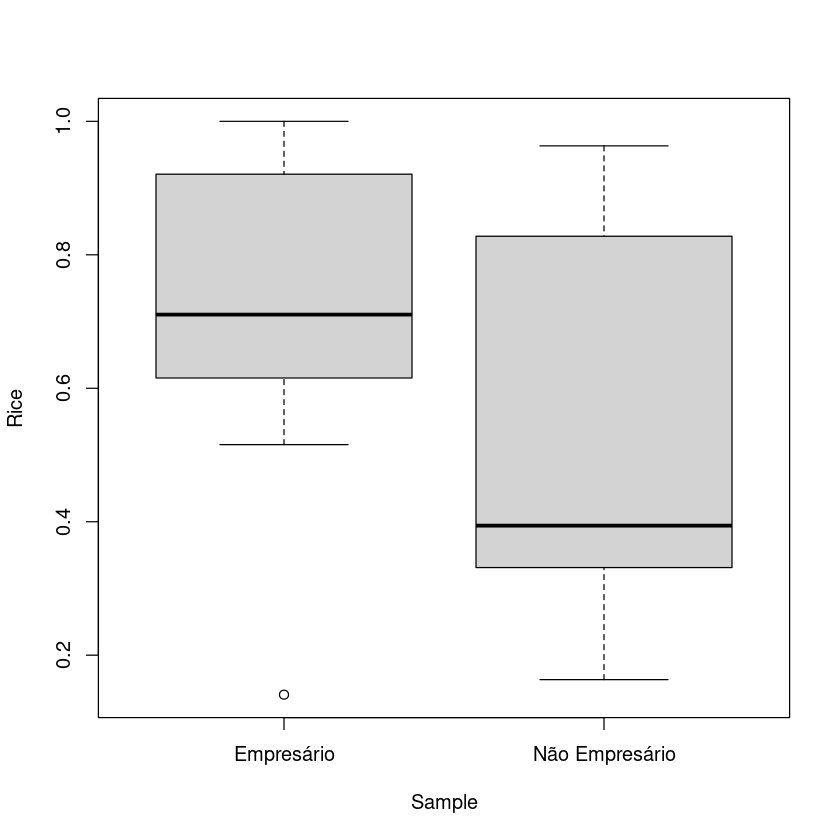

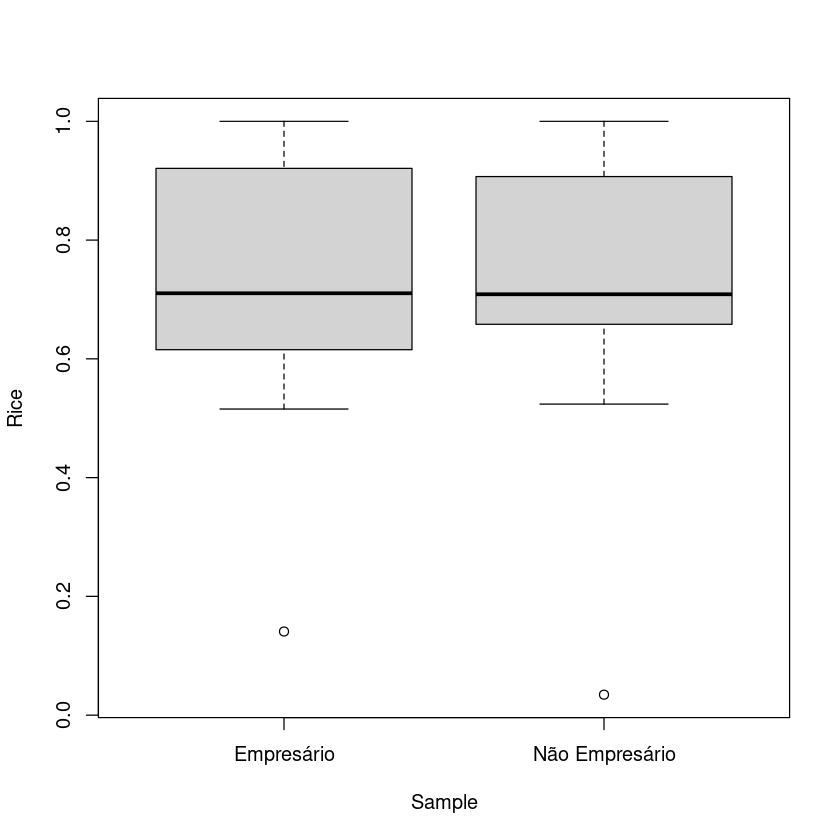

In [62]:
# Create a boxplot
boxplot(combined_result$vote_ratio ~ combined_result$sample, 
        # main = "Boxplot do Rice",
        xlab = "Sample",
        ylab = "Rice")

# Create a boxplot
boxplot(combined_result_p$vote_ratio ~ combined_result_p$sample, 
        # main = "Boxplot do Rice",
        xlab = "Sample",
        ylab = "Rice")